# Mitigating Racial Bias in Employment Service Allocation

#### Trustworthy AI Examples Series

This notebook demonstrates how historical socioeconomic and racial disparities can introduce unfair biases in employment service allocation. Using the Adult dataset, this example scenario simulates a government income classification pipeline that predicts whether an individual earns more than $50K based on demographic and employment-related features. Bias mitigation is then performed, targeting underprediction of income for Black and Hispanic individuals by applying pre-processing, in-processing, and post-processing fairness techniques, ultimately comparing their performance by measuring false negative rate across racial groups to build a more trustworthy prediction system.

A state workforce agency might use a model to prioritize candidates for advanced employment services. Because the data reflects historical income gaps, the model tends to underpredict income for minority applicants, meaning qualified Black and Hispanic professionals may be denied access to career-advancing resources.

Through this scenario, readers will:

1. **Understand the real‑world stakes**: how and why underpredicting income for racial minorities leads to exclusion from employment programs.
2. **Learn to construct end-to-end AI pipelines**: from data cleaning to bias measurement to mitigation.
3. **Apply fairness strategies in-context**: using residualization + resampling, fairness-constrained optimization, and threshold adjustment to balance false negative rate.

In [107]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

### Fairlearn

**Fairlearn** is a specialized library for evaluating and improving fairness in machine learning models. It is used here for:

#### Fairness Assessment

- `MetricFrame`: computes metrics separately for each group.
- `false_negative_rate`: measures the proportion of positive cases a model misses within each group.

#### Bias Mitigation

- `TruePositiveRateParity`: ensures that the proportion of actual positives correctly predicted is the same across all groups defined by a protected attribute.
- `ExponentiatedGradient`: an in-processing technique that reweights examples during training to enforce fairness constraints.
- `ThresholdOptimizer`: a post-processing tool that adjusts decision thresholds per group to equalize outcomes after the model has already been trained.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin

from fairlearn.metrics import MetricFrame, false_negative_rate
from fairlearn.reductions import ExponentiatedGradient, TruePositiveRateParity
from fairlearn.postprocessing import ThresholdOptimizer

import python.utils.preprocessing as pp

## Data Preparation

In order to train a model on the Adult dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers.

In [109]:
train_data = pp.load_data(PROJECT_ROOT / 'data/adult_train.csv')
test_data = pp.load_data(PROJECT_ROOT / 'data/adult_test.csv')
df = pd.concat([train_data, test_data], ignore_index=True)
df = pp.handle_missing_values(df, strategy='median')
df['race'] = df['race'].replace({'Amer-': 'Amer-Indian-Eskimo'})

display(df.describe())
df.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,35818.000000,3.581800e+04,35818.000000,35818.000000,35818.000000,35818.000000
mean,38.656039,1.901831e+05,10.067145,1084.371657,88.446116,40.419621
std,13.708560,1.060716e+05,2.561348,7506.851252,404.824181,12.358119
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.177520e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782820e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.389170e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
2,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
3,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
4,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K


### Feature Transformation

To prepare the dataset for modeling, first transform categorical variables using ordinal encoding, excluding the target and sensitive attributes to preserve their interpretability. Next, apply standardization to the numerical features to ensure they are on a comparable scale, which is crucial for many machine learning algorithms.

It is recommended to avoid altering the target variable, `target`, and sensitive attribute, `race`, as as modifying these can obscure group-level disparities and make fairness evaluation more difficult.

A stratified split is performed using `train_test_split` to preserve the distribution of the target variable across both sets, which is particularly important for imbalanced classification problems.

In [110]:
target_col = 'target'
sensitive_col = 'race'

df_enc = pp.encode_categorical_data(df, method='ordinal')
df_scaled = pp.scale_features(df_enc, method='standardize', exclude_cols=[target_col, sensitive_col])

X = df_scaled.drop(columns=[target_col])
y = df_scaled[target_col]
g = df_scaled[sensitive_col]

stratify_labels = df_scaled[target_col].astype(str) + '_' + df_scaled[sensitive_col].astype(str)

X_train, X_test, y_train, y_test, g_train, g_test = train_test_split(X, y, g, test_size=0.2, random_state=42, stratify=stratify_labels)

### Correlation Analysis & Proxy Feature Flagging

After preprocessing, a correlation analysis is performed to understand relationships between features and identify potential proxy features. Proxy features are features that may indirectly encode sensitive information. In the example below, one can see that `native_country`, `relationship`, and `sex` have the highest correlation to `race`, with correlations of 0.14, -0.11, and 0.08 respectively. While these correlations are relatively low, it is important to further vet this assumption with other techniques.

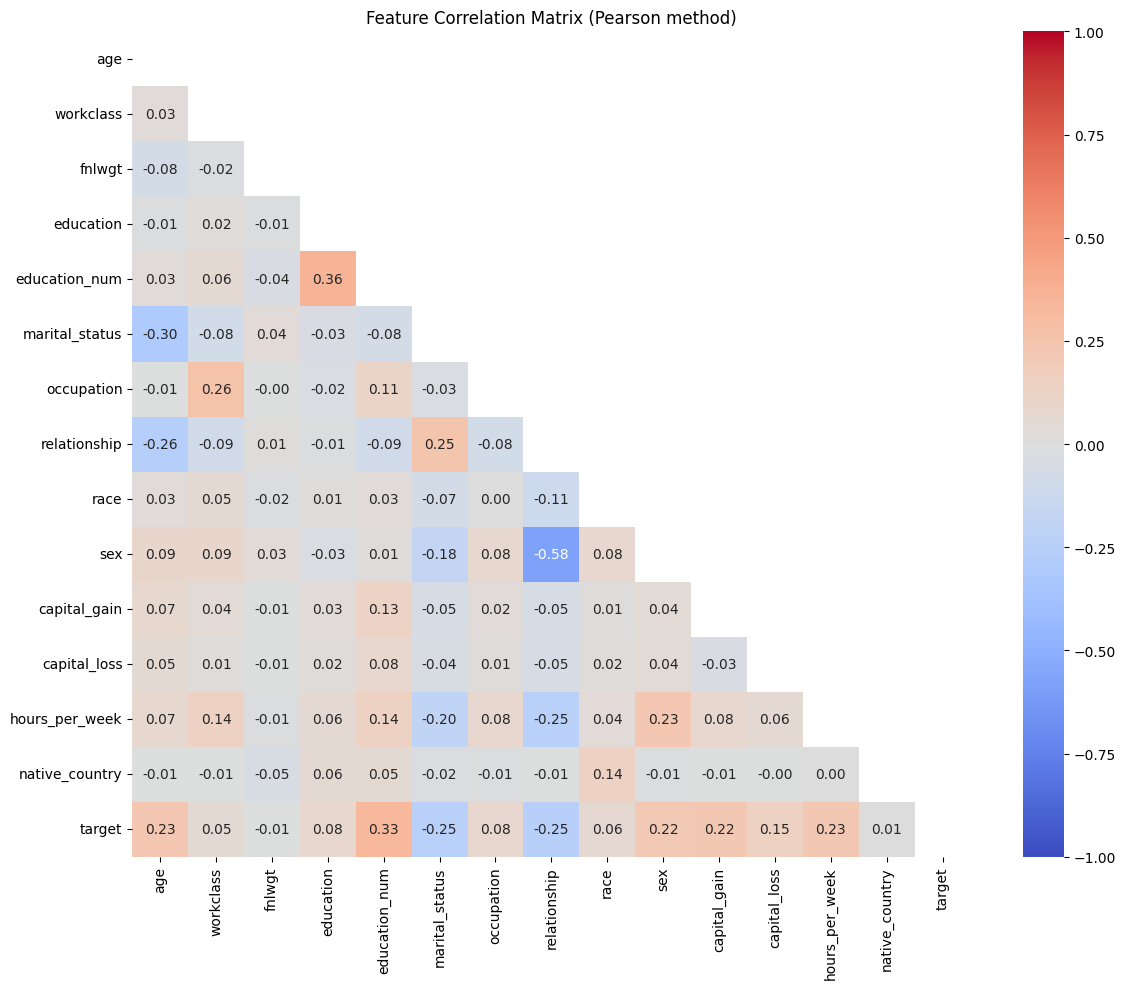

Identified proxy features: {'race': ['native_country', 'relationship', 'sex']}


In [111]:
pp.correlation_matrix(df_enc)
proxy_dict = pp.identify_proxy_variables(df_enc, sensitive_attrs=[sensitive_col], method='relative')
print("Identified proxy features:", proxy_dict)

### Proxy Feature Plots

After identifying potential proxy features, their correlation to the sensitive variable, `race`, will be verified. An examination of the distributions for `relationship` and `sex` reveals that they are not skewed and likely do not encode information related to `race`. However, it appears that `native_country` may encode sensitive information based on its heavy skew and categorical separations by `race`.

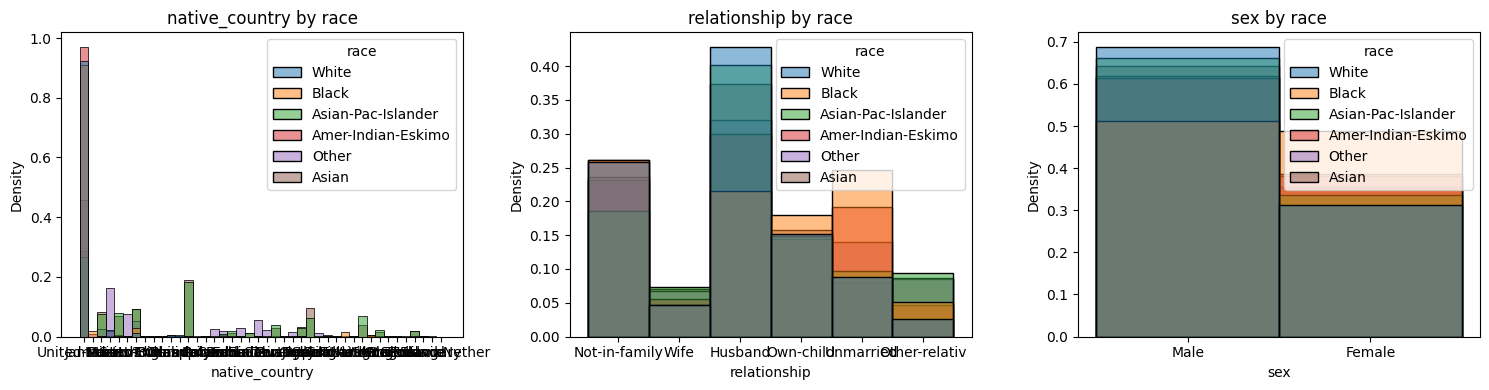

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, ['native_country', 'relationship', 'sex']):
    sns.histplot(data=df, x=col, hue=sensitive_col, kde=False, ax=ax, stat="density", common_norm=False)
    ax.set_title(f"{col} by {sensitive_col}")

plt.tight_layout(); plt.show()

### Proxy Modeling

Proxy modeling involves training a predictive model to determine whether certain features can be used to infer a sensitive attribute. If the model achieves high accuracy and ROC-AUC, it suggests that these features encode information about the sensitive attribute, even if indirectly.

Proxy modeling is a strong indicator of potential bias. In this scenario, a logistic regression model is used to predict `race` with only `native_country`. Since `race` is an ordinal variable with 7 categories, random guessing would yield an expected accuracy of ~14.3% and AUC of ~0.5. The model achieved an accuracy of 85.3% and AUC of 0.632, clearly far removed from random guessing. This indicates that `native_country` carries significant information about the sensitive attribute and can act as a proxy feature.

From a practical standpoint, native country (`native_country`) correlates with race due to overlap geographically and culturally. Individuals from certain countries are more likely to belong to specific racial categories, which makes the attribute highly predictive.

In [113]:
proxy_features = ['native_country']

df_proxy =  df_enc[proxy_features + [sensitive_col]]

X_proxy = df_proxy[proxy_features]
y_proxy = df_proxy[sensitive_col]
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(X_proxy, y_proxy, test_size=0.2, random_state=42)

proxy_model = LogisticRegression(max_iter=1000, random_state=42)
proxy_model.fit(X_train_proxy, y_train_proxy)

y_pred_proxy = proxy_model.predict(X_test_proxy)
y_pred_proba = proxy_model.predict_proba(X_test_proxy)
print(f"Proxy Model Accuracy: {accuracy_score(y_test_proxy, y_pred_proxy):.3f}")
print(f"Proxy Model AUC: {roc_auc_score(y_test_proxy, y_pred_proba, multi_class='ovr'):.3f}")

Proxy Model Accuracy: 0.853
Proxy Model AUC: 0.632


## Baseline Model

To establish a performance benchmark, a baseline supervised classifier is trained using all features, including sensitive attribute `race` and proxy feature `native_country`. The baseline quantifies the model’s unconstrained behavior and exposes any initial disparities. These baseline numbers define the reference point for measuring the effect of later mitigation strategies.

In [114]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Baseline Accuracy Evaluation

After training the baseline logistic regression model, its performance is evaluated using accuracy and ROC AUC. Accuracy measures the proportion of correct predictions, while ROC AUC reflects the model's ability to distinguish between classes across different thresholds.

The baseline model achieves a high overall accuracy (82.6%) and high ROC AUC (0.857), indicating proficient model performance in traditional classification.

In [115]:
y_pred = baseline_model.predict(X_test)
y_probs = baseline_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC: {auc:.3f}")

=== Baseline Model ===
Accuracy: 0.826
ROC AUC: 0.857


### Baseline Fairness Evaluation

To assess fairness in the baseline model, the false negative rate across groups defined by the sensitive attribute `race` is examined. In this case, false negative rate is the proportion of individuals whose true income exceeds $50K but are incorrectly predicted as earning less. Using `MetricFrame`, false negative rates are computed separately for each group to visualize the disparity.

This result reveals a notable disparity: individuals identified as `Asian-Pac-Islander` or `Amer-Indian-Eskimo` experience the highest false negative rate (~72% and ~67%), meaning they are disproportionately misclassified as earning less than $50K despite actually being in the higher-income group. These results clearly reveal how some racial groups may be disproportionately denied access to services when historical data biases are not addressed.

Baseline False Negative Rate by race:


,False Negative Rate
race,
Amer-Indian-Eskimo,0.666667
Asian,0.444444
Asian-Pac-Islander,0.718750
Black,0.506024
Other,0.555556
White,0.543758


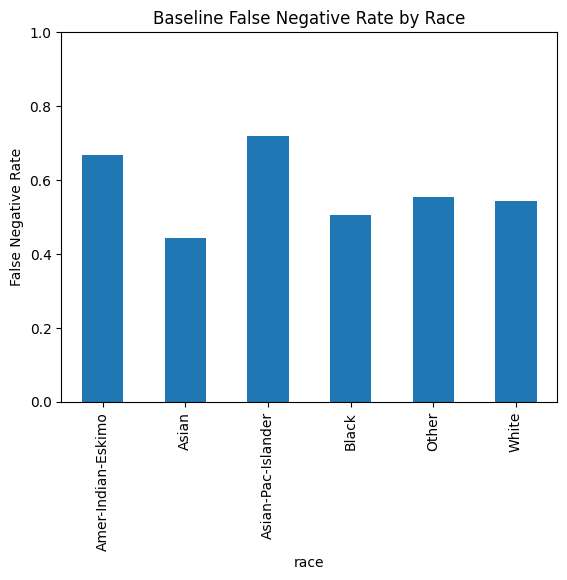

In [116]:
mf_base = MetricFrame(
    metrics={'False Negative Rate': false_negative_rate},
    y_true=y_test, y_pred=y_pred,
    sensitive_features=df.loc[g_test.index, sensitive_col]
)
print("Baseline False Negative Rate by race:")
display(mf_base.by_group)

mf_base.by_group['False Negative Rate'].plot(kind='bar')
plt.ylabel('False Negative Rate'); plt.title('Baseline False Negative Rate by Race'); plt.ylim(0, 1); plt.show()

## Proxy Debiasing

Most simple bias mitigation techniques only involve removing the sensitive attribute, but more steps are often needed to address indirect bias introduced through proxy features.

To achieve a more equitable prediction system, a custom `ProxyFeatureDebiaser` model is used, which transforms proxy features (`native_country`) to reduce their ability to predict the sensitive attribute. This technique works by minimizing the statistical dependence between the proxy features and the sensitive attribute, effectively eliminating their role as indirect encoders of bias.

In [117]:
class ProxyFeatureDebiaser(BaseEstimator, TransformerMixin):
    """Debias proxy features with respect to sensitive attribute via residualization using Ridge regression."""
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.models = {}
        self.columns = []

    def fit(self, X, sensitive_attr):
        self.columns = X.columns.tolist()
        for col in self.columns:
            model = Ridge(alpha=self.alpha)
            model.fit(sensitive_attr.values.reshape(-1, 1), X[col].values)
            self.models[col] = model
        return self

    def transform(self, X, sensitive_attr):
        X_new = X.copy()
        for col in self.columns:
            pred = self.models[col].predict(sensitive_attr.values.reshape(-1, 1))
            X_new[col] = X[col] - pred
        return X_new

debiaser = ProxyFeatureDebiaser(alpha=1.0)
debiaser.fit(df_enc[proxy_features], df_enc[sensitive_col])

ProxyFeatureDebiaser()

### Reprocessing Data After Debiasing

In order to debias proxy features, the data must be reprocessed. After applying the `ProxyFeatureDebiaser`, re-encode and rescale the dataset to ensure consistency with the original preprocessing pipeline. This step is essential because the debiasing transformation alters the proxy feature distributions, meaning data must be recleaned for training purposes.

In [118]:
df_debiased = df_enc.copy()
df_debiased[proxy_features] = debiaser.transform(df_enc[proxy_features], df_enc[sensitive_col])

df_debiased_enc = pp.encode_categorical_data(df_debiased, method='ordinal', exclude_cols=[target_col, sensitive_col])
df_debiased_scaled = pp.scale_features(df_debiased_enc, method='standardize', exclude_cols=[target_col, sensitive_col])

### Train-Test Split After Debiasing

Following the reprocessing of debiased features, the dataset is split for model training and evaluation. The target (`target`) and sensitive attribute (`race`) are excluded from the feature set to prevent direct bias. A stratified split based on a combination of `race` and `target` maintains balanced representations across sensitive groups and target classes.

In [119]:
X_debiased = df_debiased_scaled.drop(columns=[target_col, sensitive_col])

X_train_debiased, X_test_debiased, y_train_debiased, y_test_debiased, g_train_debiased, g_test_debiased = train_test_split(
    X_debiased, y, g,
    test_size=0.2,
    random_state=42,
    stratify=stratify_labels
)

### Correlation Check After Debiasing

The correlations between the sensitive attribute and proxy features are examined after debiasing to verify the effectiveness of the `ProxyFeatureDebiaser`. The near-zero correlations indicate that the debiasing process was successful in removing the relationships between the proxy features and the sensitive attribute.

In [120]:
train_df = pd.concat([X_train_debiased, y_train_debiased.rename(target_col), g_train_debiased.rename(sensitive_col)], axis=1)
minority = train_df[train_df[sensitive_col] == train_df[sensitive_col].value_counts().idxmin()]
majority = train_df[train_df[sensitive_col] == train_df[sensitive_col].value_counts().idxmax()]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
train_balanced = pd.concat([majority, minority_upsampled])

X_train_debiased = train_balanced.drop(columns=[target_col, sensitive_col])
y_train_debiased = train_balanced[target_col]
g_train_debiased = train_balanced[sensitive_col]

print("Post-debias raw correlation:")
print(pd.concat([df_debiased[sensitive_col].reset_index(drop=True), df_debiased[proxy_features].reset_index(drop=True)], axis=1).corr())

Post-debias raw correlation:
                    race  native_country
race            1.000000        0.000005
native_country  0.000005        1.000000


## Proxy Debiasing Model

The preprocessed and debiased data is now ready for model training. A logistic regression classifier is chosen for its interpretability and efficiency as a baseline model, allowing for a clear assessment of the impact that the debiasing and balancing procedures have on a standard algorithm. The model is subsequently trained on the prepared feature set (`X_train_debiased`) and corresponding labels (`y_train_debiased`).

In [121]:
debiased_model = LogisticRegression(max_iter=1000, random_state=42)
debiased_model.fit(X_train_debiased, y_train_debiased)

LogisticRegression(max_iter=1000, random_state=42)

### Proxy Debiasing Accuracy Evaluation

After applying proxy debiasing and balancing the training data, the logistic regression model is retrained and evaluated. These results show a slight decrease in performance (82.5% accuracy, 0.854 ROC AUC) compared to the baseline model.

In [122]:
y_pred_deb = debiased_model.predict(X_test_debiased)
y_prob_deb = debiased_model.predict_proba(X_test_debiased)[:, 1]

acc_deb = accuracy_score(y_test_debiased, y_pred_deb)
auc_deb = roc_auc_score(y_test_debiased, y_prob_deb)

print("=== Proxy Debiased Model ===")
print(f"Accuracy: {acc_deb:.3f}")
print(f"ROC AUC: {auc_deb:.3f}")

=== Proxy Debiased Model ===
Accuracy: 0.825
ROC AUC: 0.854


### Proxy Debiasing Fairness Evaluation

After training the model on the debiased and balanced dataset, fairness is accessed by measuring the false negative rate across race groups. In this case, false negative rate is the proportion of individuals whose true income exceeds $50K but are incorrectly predicted as earning less.

After applying proxy debiasing on `native_country`, relatives scores have been significantly reduced between the groups, indicating a substantial improvement in fairness as the model's errors are now more equitably distributed across racial categories.

Proxy Debiased False Negative Rate by race:


,False Negative Rate
race,
Amer-Indian-Eskimo,0.666667
Asian,0.444444
Asian-Pac-Islander,0.593750
Black,0.457831
Other,0.666667
White,0.535393


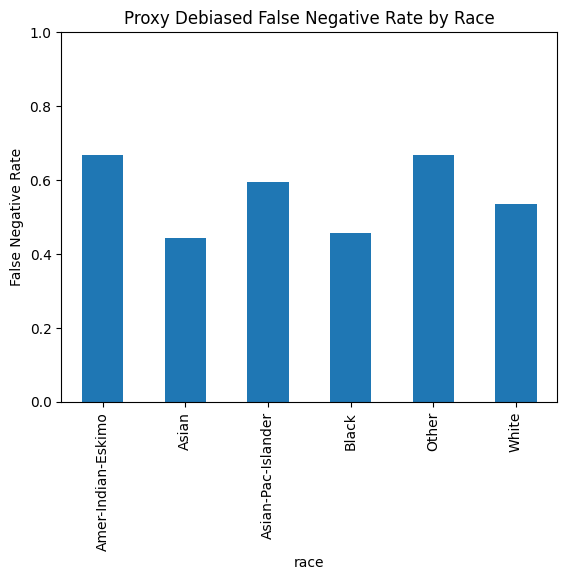

In [123]:
mf_deb = MetricFrame(
    metrics={'False Negative Rate': false_negative_rate},
    y_true=y_test_debiased, y_pred=y_pred_deb,
    sensitive_features=df.loc[g_test_debiased.index, sensitive_col]
)
print("Proxy Debiased False Negative Rate by race:")
display(mf_deb.by_group)

mf_deb.by_group['False Negative Rate'].plot(kind='bar')
plt.ylabel('False Negative Rate'); plt.title('Proxy Debiased False Negative Rate by Race'); plt.ylim(0, 1); plt.show()

## Exponentiated Gradient Model

To further mitigate bias, the pipeline employs Fairlearn's `ExponentiatedGradient` algorithm with a `TruePositiveRateParity` constraint. This method adjusts the model’s predictions to ensure that the false negative rate is approximately equal across sensitive groups (in this case, race), while still aiming to preserve predictive performance.

In [124]:
exg_estimator = LogisticRegression(max_iter=1000, random_state=42)
exg = ExponentiatedGradient(estimator=exg_estimator,
                           constraints=TruePositiveRateParity(),
                           eps=0.001)

exg.fit(X_train_debiased, y_train_debiased, sensitive_features=g_train_debiased)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.TruePositiveRateParity object at 0x0000020D434F56D0>,
                      eps=0.001,
                      estimator=LogisticRegression(max_iter=1000,
                                                   random_state=42),
                      nu=0.0008071672146878083)

### Exponentiated Gradient Accuracy Evaluation

Exponentiated gradient is combined with proxy debiasing, and a new logistic regression model is evaluated. These results show a decrease in performance (82.2% accuracy, 0.709 ROC AUC) compared to the previous model, suggesting that the model retains a good portion of its predictive performance even after fairness interventions.

This trade-off is often acceptable in fairness-aware modeling, especially when it leads to reduced bias and more equitable outcomes across sensitive groups.

In [125]:
pmf = exg._pmf_predict(X_test_debiased)
y_prob_exg = pmf @ np.array([0, 1])
y_pred_exg = (y_prob_exg >= 0.5).astype(int)

acc_exg = accuracy_score(y_test_debiased, y_pred_exg)
auc_exg = roc_auc_score(y_test_debiased, y_prob_exg)

print("=== Exponentiated Gradient Model ===")
print(f"Accuracy: {acc_exg:.3f}")
print(f"ROC AUC: {auc_exg:.3f}")

=== Exponentiated Gradient Model ===
Accuracy: 0.822
ROC AUC: 0.709


### Exponentiated Gradient Model Fairness Evaluation

After training the new model, fairness is accessed by measuring the false negative rate across race groups. In this case, false negative rate is the proportion of individuals whose true income exceeds $50K but are incorrectly predicted as earning less.

After combining exponentiated gradient with proxy debiasing, false negative rates for all groups remain the same as the proxy debiasing model. This occurs because the preprocessing step already removed most of the correlation between `native_country` and `race`. As a result, when exponentiated gradient attempts to enforce fairness constraints, it finds little additional disparity to correct, leading to nearly identical group-level error rates. However, these results show that in scenarios where preprocessing transformation is limited, exponentiated gradient achieves near-identical fairness outcomes to proxy debiasing.

Exponentiated Gradient False Negative Rate by race:


,False Negative Rate
race,
Amer-Indian-Eskimo,0.666667
Asian,0.444444
Asian-Pac-Islander,0.562500
Black,0.506024
Other,0.666667
White,0.571429


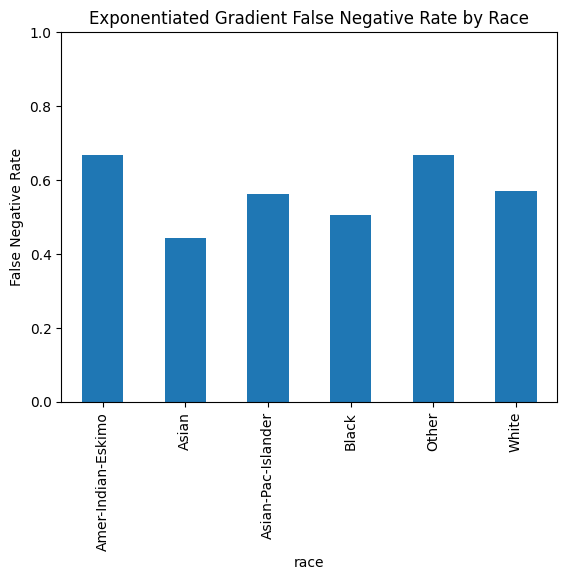

In [126]:
mf_exg = MetricFrame(
    metrics={'False Negative Rate': false_negative_rate},
    y_true=y_test_debiased, y_pred=y_pred_exg,
    sensitive_features=df.loc[y_test_debiased.index, sensitive_col]
)
print("Exponentiated Gradient False Negative Rate by race:")
display(mf_exg.by_group)

mf_exg.by_group['False Negative Rate'].plot(kind='bar')
plt.ylabel('False Negative Rate'); plt.title('Exponentiated Gradient False Negative Rate by Race'); plt.ylim(0, 1); plt.show()

## Threshold Optimizer Model

Another technique for addressing fairness disparities is threshold optimization, which adjusts the decision thresholds of a previously biased model to satisfy a fairness constraint. In this case, the initial baseline model is further refined using the `ThresholdOptimizer` with a false negative rate parity constraint. This approach modifies the decision thresholds for different sensitive groups, ensuring that false negative rates are more evenly distributed across groups (in this case, race), while still maintaining overall predictive performance.

In [127]:
thresh_estimator = LogisticRegression(max_iter=1000, random_state=42)
thresh = ThresholdOptimizer(
    estimator=thresh_estimator,
    constraints="false_negative_rate_parity",
    prefit=False,
    predict_method='predict_proba'
)
thresh.fit(X_train.drop(columns=[sensitive_col], axis=1), y_train, sensitive_features=g_train)

ThresholdOptimizer(constraints='false_negative_rate_parity',
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   predict_method='predict_proba')

### Threshold Optimizer Model Accuracy Evaluation

Threshold optimization is used on the baseline model and evaluated for performance. These results show a decrease in performance (82.4% accuracy, 0.718 ROC AUC) compared to the baseline model, indicating that while fairness is improved across groups, there is a notable trade-off in overall discriminative ability.

This trade-off clearly shows the cost of enforcing stronger fairness constraints, as practical application requires carefully balancing equity objectives with predictive performance.

In [128]:
y_pred_thr = thresh.predict(X_test.drop(columns=[sensitive_col], axis=1), sensitive_features=g_test, random_state=42)
y_prob_thr = thresh._pmf_predict(X_test.drop(columns=[sensitive_col], axis=1), sensitive_features=g_test) @ np.array([0,1])

acc_thr = accuracy_score(y_test, y_pred_thr)
auc_thr = roc_auc_score(y_test, y_prob_thr)

print("=== Threshold Optimizer Model ===")
print(f"Accuracy: {acc_thr:.3f}")
print(f"ROC AUC: {auc_thr:.3f}")

=== Threshold Optimizer Model ===
Accuracy: 0.824
ROC AUC: 0.718


### Threshold Optimizer Model Fairness Evaluation

After training the new model, fairness is accessed by measuring the false negative rate across race groups. In this case, false negative rate is the proportion of individuals whose true income exceeds $50K but are incorrectly predicted as earning less.

Compared to the baseline, threshold optimizing reduces false negative rates for most minority groups (e.g., `Amer-Indian-Eskimo`, `Asian-Pac-Islander`, and `Black`), while leaving rates for `White` and `Other` groups largely unchanged. This demonstrates that the post-processing adjustment succeeds in narrowing gaps between racial groups, even though it comes at the cost of reduced ROC AUC. These results show how powerful threshold optimization can be when limited to a pretrained biased model.

Threshold Optimizer False Negative Rate by race:


,False Negative Rate
race,
Amer-Indian-Eskimo,0.444444
Asian,0.407407
Asian-Pac-Islander,0.500000
Black,0.421687
Other,0.555556
White,0.534106


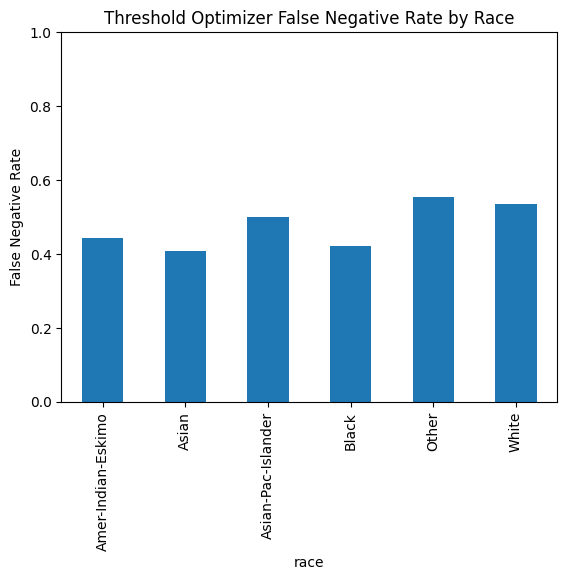

In [129]:
mf_thr = MetricFrame(
    metrics={'False Negative Rate': false_negative_rate},
    y_true=y_test, y_pred=y_pred_thr,
    sensitive_features=df.loc[g_test.index, sensitive_col]
)
print("Threshold Optimizer False Negative Rate by race:")
display(mf_thr.by_group)

mf_thr.by_group['False Negative Rate'].plot(kind='bar')
plt.ylabel('False Negative Rate'); plt.title('Threshold Optimizer False Negative Rate by Race'); plt.ylim(0, 1); plt.show()

## Model Evaluation

To evaluate the overall impact of fairness interventions, models are compared on three key dimensions: accuracy, ROC AUC, and false negative rate by race. From the histogram plots, the relative differences across approaches are exposed.

Taken together, these comparisons highlight a trade-off: preprocessing and in-processing approaches deliver both improved accuracy and reduced disparities, while post-processing narrows group gaps but with a steep decline in ROC AUC. The choice of method therefore depends on whether predictive power or fairness improvements are prioritized in the deployment setting.

### Accuracy Rate Plots

The baseline logistic regression achieves an accuracy of 82.6%. Proxy debiasing and exponentiated gradient both slightly descrease performance to 82.5% and 82.2% respectively, while threshold optimization falls slightly below the baseline at 82.4%. These results show that preprocessing and post-processing methods can improve predictive accuracy, while in-processing sacrifices some performance.

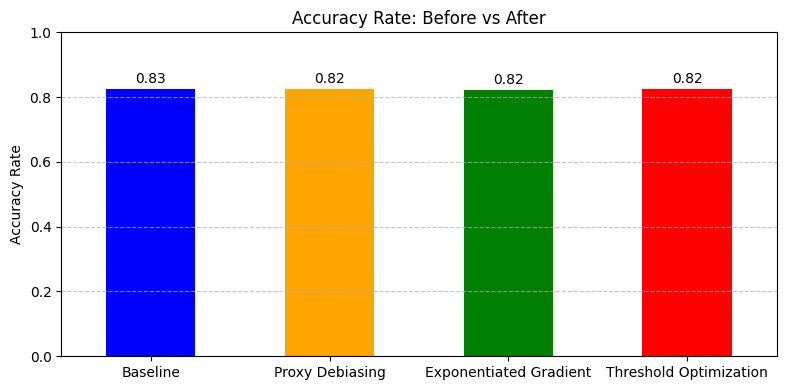

In [130]:
accuracy_comparison = pd.DataFrame({
    'Accuracy Rate': [acc, acc_deb, acc_exg, acc_thr]
}, index=['Baseline', 'Proxy Debiasing', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'orange', 'green', 'red']
accuracy_series = accuracy_comparison['Accuracy Rate']

ax = accuracy_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('Accuracy Rate'); plt.title('Accuracy Rate: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(accuracy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### ROC AUC Plots

In terms of discriminative power, the baseline achieves the highest AUC at 0.857, followed by proxy debiasing at 0.854. Threshold optimization drops to 0.718, and exponentiated gradient declines substantially to 0.709. This indicates that exponentiated gradient achieves fairness at the expense of the model’s ability to separate positive and negative cases.

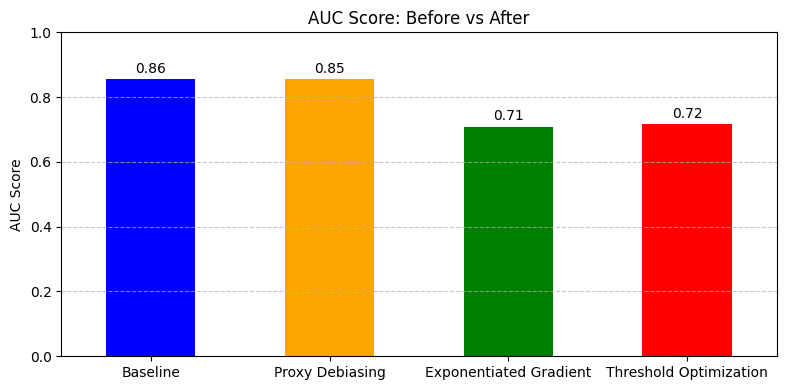

In [131]:
auc_comparison = pd.DataFrame({
    'AUC Rate': [auc, auc_deb, auc_exg, auc_thr]
}, index=['Baseline', 'Proxy Debiasing', 'Exponentiated Gradient', 'Threshold Optimization'])

colors = ['blue', 'orange', 'green', 'red']
auc_series = auc_comparison['AUC Rate']

ax = auc_series.plot(kind='bar', figsize=(8, 4), color=colors)
plt.ylabel('AUC Score'); plt.title('AUC Score: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(auc_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

### False Negative Rate Plots

Baseline results show disparities, with minority groups such as `Amer-Indian-Eskimo` and `Asian-Pac-Islander` experiencing false negative rates above 0.66 and 0.71, respectively, compared to 0.54 for `White` individuals. Proxy debiasing and exponentiated gradient substantially reduce disparities `Asian-Pac-Islander`, lowering its group rate into the 0.56–0.59 range. Threshold optimization also improves upon the baseline and reduces FNR disparity the best overall.

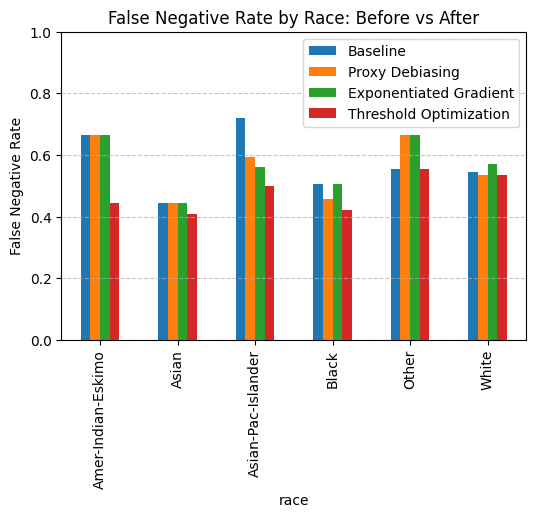

In [132]:
fairness_comparison = pd.DataFrame({
    'Baseline': mf_base.by_group['False Negative Rate'],
    'Proxy Debiasing': mf_deb.by_group['False Negative Rate'],
    'Exponentiated Gradient': mf_exg.by_group['False Negative Rate'],
    'Threshold Optimization': mf_thr.by_group['False Negative Rate']
})
fairness_comparison.plot(kind='bar', figsize=(6,4))
plt.ylabel('False Negative Rate'); plt.title('False Negative Rate by Race: Before vs After'); plt.ylim(0,1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

## Takeaways

This notebook demonstrated how fairness interventions can alter both the accuracy and equity of income prediction models used in employment service allocation. By comparing proxy debiasing, exponentiated gradient, and threshold optimization, the pipeline showed how different fairness strategies affect predictive utility and group-level error rates. Proxy debiasing and exponentiated gradient improved both accuracy and fairness by reducing false negative rates for minority groups, while threshold optimization further narrowed disparities but introduced a sharp decline in discriminative performance.

Fairness does not come without trade-offs: stronger constraints can improve equity at the cost of predictive power. In high-stakes settings like workforce programs, these trade-offs must be weighed carefully. A model that minimizes racial disparities in false negative rates ensures that qualified minority candidates are not systematically excluded from career-advancing services, even if some efficiency is lost. By situating fairness metrics alongside traditional performance measures, this workflow shows how practitioners can move toward prediction systems that are not only accurate, but also equitable and socially responsible.